# TP9 Exercice 2

<br>

Le but de cet exercice est de classifier les textes d'un corpus de textes sur différents sujets, de manière à regrouper les textes portant sur le même sujet. La méthode utilisée (statistiques sur un _sac de mots_) admet des variantes plus efficaces que ce que l'on utilise dans ce TP; ces variantes font toujours l'objet de recherches.

Nous allons utiliser un jeu de données de `scikit-learn`: des textes provenant de newsgroups (les ancètres des forums) consacrés à un sujet.

L'exercice est inspiré de [la documentation scikit-learn](https://scikit-learn.org/0.18/auto_examples/text/document_clustering.html)


On commence par charger les bibliothèques utiles:

In [10]:
# "magic function" Jupyter pour l'affichage des graphiques dans le carnet:
%matplotlib inline

import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import cluster

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import linkage, fcluster

import numpy as np
import matplotlib.pyplot as plt

Ensuite on charge des textes venant de quatre groupes de discussion (`categories`) provenant du dataset _20 newsgroups_:

In [2]:
categories = [
    'misc.forsale',
    'rec.sport.baseball',
    'comp.graphics',
    'sci.space',
]

print("Loading 20newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

Loading 20newsgroups dataset for categories:
['misc.forsale', 'rec.sport.baseball', 'comp.graphics', 'sci.space']
3929 documents
4 categories



On voit à l'aide des cellules suivantes que l'objet `dataset` a en particulier des attributs `target` (un entier représentant la catégorie du texte, ici entre 0 et 3 car on a extrait 4 catégories), `target_names` (les noms des catégories en anglais, dans l'ordre des entiers de `target`), et `data` (le texte des messages):

In [3]:
print(dir(dataset))   #  dir permet de lister les attributs et méthodes d'un objet
print("contenu de l'attribut target: %a" % dataset.target)
print("contenu de l'attribut target_names: %a" % dataset.target_names)

print()
print()
no_doc=10   # essayez avec d'autres textes parmi les 3929 chargés
print("Document no: %d" % no_doc)
print("numéro de catégorie: %d" % dataset.target[no_doc]) 
print("ce qui correspond au sujet: %s" % dataset.target_names[dataset.target[no_doc]])
print()
print("Le texte est:")
print()
print(dataset.data[no_doc])   # vérifiez que le texte a l'air cohérent avec le sujet

['DESCR', 'data', 'filenames', 'target', 'target_names']
contenu de l'attribut target: array([2, 1, 2, ..., 2, 2, 0], dtype=int64)
contenu de l'attribut target_names: ['comp.graphics', 'misc.forsale', 'rec.sport.baseball', 'sci.space']


Document no: 10
numéro de catégorie: 3
ce qui correspond au sujet: sci.space

Le texte est:

From: nsmca@aurora.alaska.edu
Subject: Re: Why not give $1 billion to first year-long moon residents?
Article-I.D.: aurora.1993Apr20.141137.1
Organization: University of Alaska Fairbanks
Lines: 33
Nntp-Posting-Host: acad3.alaska.edu

In article <1993Apr20.101044.2291@iti.org>, aws@iti.org (Allen W. Sherzer) writes:
> In article <1qve4kINNpas@sal-sun121.usc.edu> schaefer@sal-sun121.usc.edu (Peter Schaefer) writes:
> 
>>|> > Announce that a reward of $1 billion would go to the first corporation 
>>|> > who successfully keeps at least 1 person alive on the moon for a year. 
> 
>>Oh gee, a billion dollars!  That'd be just about enough to cover the cost of the
>>fea

L'objectif est de parvenir à classifier les textes du corpus par sujet, en supposant bien entendu que l'on ne connaisse pas le newsgroup d'appartenance. On va donc chercher une classification non-supervisée sur les textes stockés dans `dataset.data`, l'information dans `dataset.target` nous servira uniquement pour vérifier à la fin le résultat de notre classification.

Les algorithmes de clustering traitent des points dans un espace (vectoriel) muni d'une distance. La première étape est donc de transformer chaque texte en un vecteur.

Une approche standard dans le domaine de la fouille de textes est la transformation TF-IDF, décrite [sur wikipedia](https://en.wikipedia.org/wiki/TF-IDF) (lisez le début de la page).

Il y a deux étapes: 
* on considère un sous-ensemble des mots présents dans tous les textes à classifier (un "sac de mots", défini ci-dessous), et on calcule pour chaque texte la fréquence d'occurrences de chacun des mots du vocabulaire: à ce stade chaque texte est représenté par un vecteur de fréquences (étape TF: _term frequency_)
* les vecteurs sont normalisés de manière à ce que les mots présents dans beaucoup de textes du corpus (donc peu discriminants) aient un poids plus faible dans le vecteur représentant un texte (étape IDF: _inverse document frequency_). Intuitivement, si un mot apparaît fréquemment dans un document, son importance pour le sujet à identifier n'est pas la même s'il est de toute façon présent dans tous les documents (indépendamment de leur sujet) ou non. 

Scikit-learn propose une fonction permettant de calculer la représentation TF-IDF des textes du corpus (plus de détails [ici](https://scikit-learn.org/0.18/modules/feature_extraction.html#text-feature-extraction), complément d'information). Dans la cellule suivante, on associe à chaque texte du corpus un vecteur TF-IDF. Pour former le "sac de mots" (_bag of words_) au préalable, on ne tient pas compte des mots trop courants (`max_df`: les mots présents dans plus de 50% des documents sont éliminés) ou trop rares (`min_df`: les mots présents dans moins de deux documents dans le corpus sont éliminés), ainsi que des mots trop courants en anglais (`stop_words`, contenus dans une liste pré-définie). De manière à limiter les temps de calcul (et éviter la malédiction de la dimensionalité, comme on le verra plus tard), on construit des vecteurs de dimension $N$ en ne gardant comme vocabulaire que les $N$ mots les plus fréquents du corpus (on n'utilise pas `min_df`).

In [4]:
N=1000
vectorizer = TfidfVectorizer(max_features=N,max_df=0.5,stop_words='english')
vectors = vectorizer.fit_transform(dataset.data)

print("nombre de documents représentés %d" %vectors.shape[0])
print("nombre de mots dans le vocabulaire %d" %vectors.shape[1])

nombre de documents représentés 3929
nombre de mots dans le vocabulaire 1000


A ce stade, `vectors[no_doc]` est un vecteur TF_IDF de dimension $N$ représentant le document d'indice $no_{doc}$. 

Le vocabulaire extrait est le suivant (essayez aussi sans `stop_words='english'` dans la cellule précédente, et différentes valeurs de $N$):

In [5]:
print(vectorizer.vocabulary_)

{'scott': 792, 'fly': 359, 'rule': 769, 'college': 216, 'ny': 618, '16': 18, 'question': 722, 'believe': 156, 'does': 300, 'deal': 275, 'situation': 820, 'ball': 145, 'advance': 91, 'point': 682, 'leave': 508, 'base': 147, 'early': 312, 'hits': 425, 'ground': 401, 'appreciated': 121, 'com': 221, 'mark': 555, 'robert': 762, 'just': 486, 'love': 537, 'video': 948, 'red': 741, '100': 9, 'order': 635, 'don': 303, 'mike': 572, 'cc': 196, 'columbia': 220, 'michael': 571, 'jack': 470, 'morris': 589, 'nntp': 611, 'posting': 689, 'host': 431, 'reply': 747, 'university': 921, '44': 62, 'article': 128, 'ca': 184, 'writes': 985, 'cs': 259, 'cornell': 248, 'ted': 875, 'greg': 400, 'lost': 534, 'bit': 163, 'edge': 317, 'start': 850, 'years': 993, 'ago': 94, 'average': 141, 'year': 992, 'goes': 390, 'better': 160, 'good': 392, 'bad': 144, 'yes': 994, 'run': 770, 'gives': 388, 'said': 774, 'boston': 174, 'world': 981, 'series': 803, 'probably': 702, 'hall': 409, 'future': 373, 'say': 782, 'toronto': 9

A titre illustratif, le code suivant représente le vecteur associé à quatre documents: en ordonnée on voit la statistique TF-IDF, en abscisse le numéro du mot dans le "sac de mots". (pas besoin de comprendre la syntaxe)

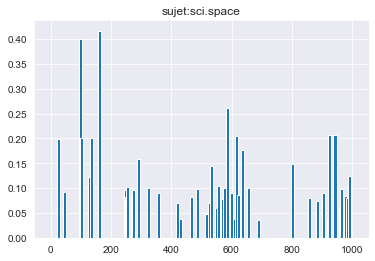

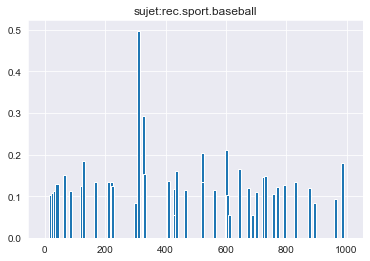

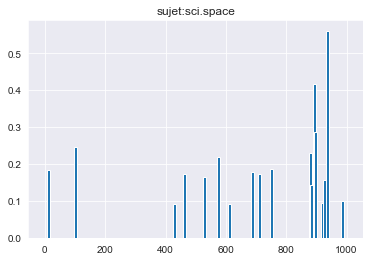

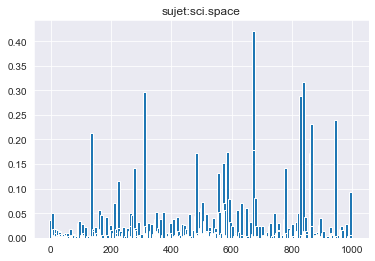

In [6]:
# l'affichage peut prendre un peu de temps

plt.figure();
no_doc=10
plt.bar(np.arange(N),np.asarray(vectors[no_doc].todense())[0],width=10);
plt.title("sujet:"+dataset.target_names[dataset.target[no_doc]]);

plt.figure();
no_doc=100
plt.bar(np.arange(N),np.asarray(vectors[no_doc].todense())[0],width=10);
plt.title("sujet:"+dataset.target_names[dataset.target[no_doc]]);

plt.figure();
no_doc=50
plt.bar(np.arange(N),np.asarray(vectors[no_doc].todense())[0],width=10);
plt.title("sujet:"+dataset.target_names[dataset.target[no_doc]]);

plt.figure();
no_doc=1000
plt.bar(np.arange(N),np.asarray(vectors[no_doc].todense())[0],width=10);
plt.title("sujet:"+dataset.target_names[dataset.target[no_doc]]);

<br>

__Travail à faire__: utilisez les algorithmes de classification hiérarchique (single-linkage, Ward) et k-means pour classifier les vecteurs TF-IDF (donc les textes) en quatre classes. Les `labels` (valeurs entre 0 et 3) calculés pour chaque vecteur TF-IDF correspondent au numéro de la classe identifiée.

On utilisera `AgglomerativeClustering` avec les options `linkage='single'` et `linkage='ward'` (cf __[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)__ et MiniBatchKmeans (cf __[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)__).

In [7]:
# votre code:
# Labels single :
clusterSingle = AgglomerativeClustering(n_clusters=)


Observez les différences de temps de calcul (obtenus en faisant la différence entre les valeurs retournées par `time.time()`).

<br>

Nous cherchons à présent à valider les classifications obtenues. La difficulté dans une classification non-supervisée est que les labels calculés sont arbitraires: le label 0 d'une classification n'a pas de raison de correspondre au "vrai" label 0. Commencez par afficher les labels attribués par chaque méthode aux 30 premiers textes:

In [8]:
# votre code:


On dispose des [matrices de confusion](https://scikit-learn.org/0.17/modules/generated/sklearn.metrics.confusion_matrix.html) (à lire)

Que peut-on dire des résultats suivants?

In [9]:
from sklearn.metrics import confusion_matrix
print("matrice de confusion pour 'single-linkage':")
print(confusion_matrix(dataset.target,labels_single))
plt.figure()
plt.imshow(confusion_matrix(dataset.target,labels_single))  # représentation visuelle
plt.colorbar();
print()
print("matrice de confusion pour 'Ward':")
print(confusion_matrix(dataset.target,labels_ward))
plt.figure()
plt.imshow(confusion_matrix(dataset.target,labels_ward))  # représentation visuelle
plt.colorbar();
print()
print("matrice de confusion pour 'KMeans':")
print(confusion_matrix(dataset.target,labels_KM))
plt.figure()
plt.imshow(confusion_matrix(dataset.target,labels_KM))  # représentation visuelle
plt.colorbar();

matrice de confusion pour 'single-linkage':


NameError: name 'labels_single' is not defined

### Pour les plus rapides

Testez l'algorithme avec une valeur grande de $N$ (taille du sac de mots, et aussi dimensionnalité de la représentation TF-IDF de chaque texte), et avec une valeur faible. Qu'en conclure? 

Essayez également d'identifier plus de quatre sujets. Représentez le _elbow plot_ pour les K-means.

Etendez vos résultats à l'ensemble du jeu de données `20newsgroups`.
